# PyKEEN Tutorial

This tutorial will guide you through the process of using PyKEEN for knowledge graph embedding. We will cover the following topics:

1. Data Preparation
2. Creating SPO triples
3. Setting up Models
4. Evaluations

Before we start, make sure you have installed the PyKEEN library. If not, you can install it by running `!pip install pykeen` in a code cell.

In [1]:
import sys
sys.path.append('../..')
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# from ampligraph.evaluation import train_test_split_no_unseen, evaluate_performance, mr_score, mrr_score, hits_at_n_score
# from ampligraph.latent_features import TransE
from ampligraph.utils import save_model, restore_model

## 1. Data Preparation

In this section, we will load and prepare our data. The data should be in a TSV (Tab-Separated Values) format. We will use pandas to load the data and prepare it for PyKEEN.

In [3]:
import pandas as pd

# Define the subjects, predicates, and objects
subjects =   ['Alice', 'Bob', 'Charlie', 'David', 'Eve', 'Alice', 'Bob', 'David', 'Eve', 'Frank', 'David']
predicates = ['like', 'like', 'like', 'like', 'like', 'has', 'has', 'has' , 'has','has', 'has']
objects =    ['movie', 'movie', 'movie', 'music', 'music', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat']

# Create a dataframe
df = pd.DataFrame({'subject': subjects, 'predicate': predicates, 'object': objects})

# Save the dataframe to a TSV file
df.to_csv('dataset10.csv', sep=',', index=False, header=False)
df.to_csv('dataset10.tsv', sep='\t', index=False, header=False)

df

,subject,predicate,object
0,Alice,like,movie
1,Bob,like,movie
2,Charlie,like,movie
3,David,like,music
4,Eve,like,music
5,Alice,has,cat
6,Bob,has,cat
7,David,has,dog
8,Eve,has,dog
9,Frank,has,dog


## 2. Creating SPO triples

Once we have our data loaded, we need to create SPO (Subject-Predicate-Object) triples. These triples represent the relationships between entities in our knowledge graph. In PyKEEN, we can use the `TriplesFactory` class to create these triples.

In [4]:
# 2. Creating SPO triples
# Load the triples from the CSV file
from ampligraph.datasets import load_from_csv
triples = load_from_csv('.', 'dataset10.tsv', sep='\t')
training, validation, testing  = [triples, triples, triples]
triples

array([['Alice', 'like', 'movie'],
       ['Bob', 'like', 'movie'],
       ['Charlie', 'like', 'movie'],
       ['David', 'like', 'music'],
       ['Eve', 'like', 'music'],
       ['Alice', 'has', 'cat'],
       ['Bob', 'has', 'cat'],
       ['David', 'has', 'dog'],
       ['Eve', 'has', 'dog'],
       ['Frank', 'has', 'dog'],
       ['David', 'has', 'cat']], dtype=object)

In [5]:
# training, validation, testing = triples_factory.split(ratios=(.6, .2, .2))
# training = triples_factory
# validation = triples_factory
# testing = triples_factory

from pykeen.triples import TriplesFactory
# Assuming your dataframe has columns 'subject', 'predicate', 'object'
triples_factory = TriplesFactory.from_labeled_triples(
    triples=df[['subject', 'predicate', 'object']].values,
)

d=triples_factory

id_to_entity={v: k for k, v in d.entity_to_id.items()}
id_to_relation={v: k for k, v in d.relation_to_id.items()}

for i in d.map_triples(d.triples):
    s,p,o =int(i[0]), int(i[1]), int(i[2])
    h,r,t = id_to_entity[s], id_to_relation[p], id_to_entity[o]
    print(f"{s:2d}:{h:7}{p:2d}:{r:7} {o:2d}:{t:7}")

WARNING - Reconstructing all label-based triples. This is expensive and rarely needed.
 0:Alice   0:has      6:cat    
 0:Alice   1:like     8:movie  
 1:Bob     0:has      6:cat    
 1:Bob     1:like     8:movie  
 2:Charlie 1:like     8:movie  
 3:David   0:has      6:cat    
 3:David   0:has      7:dog    
 3:David   1:like     9:music  
 4:Eve     0:has      7:dog    
 4:Eve     1:like     9:music  
 5:Frank   0:has      7:dog    


/home/wasit/miniconda3/envs/demokg/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3. Setting up Models

Now that we have our triples, we can set up our knowledge graph embedding model. PyKEEN provides several models for this purpose. In this tutorial, we will use the TransE model as an example. We will also split our data into training and testing sets.

In [84]:
# 3. Setting up Models
# Define the model
# Import the KGE model
from ampligraph.latent_features import ScoringBasedEmbeddingModel

# you can continue training from where you left after restoring the model
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./transe_train_logs')

# create the model with transe scoring function
model = ScoringBasedEmbeddingModel(eta=2,
                                   k=10,#embedding_dim=3
                                   scoring_type='TransE')


# model = TransE(batches_count=100, seed=0, epochs=50, k=3, eta=5,
#                 optimizer='adam', optimizer_params={'lr':0.001},
#                 loss='multiclass_nll', regularizer='LP', regularizer_params={'p':3, 'lambda':1e-5},
#                 verbose=True)

# Split the data into training and test sets
# X_train, X_test = train_test_split_no_unseen(np.array(triples), test_size=2)

# Fit the model
# model.fit(X_train)

# Let's create an adam optimizer with customized learning rate =0.005
adam = tf.keras.optimizers.Adam(learning_rate=0.1)
# Let's compile the model with self_advarsarial loss of default parameters
model.compile(optimizer=adam, loss='self_adversarial')

# fit the model to data.
model.fit(training,
             batch_size=10000,
             epochs=50,
             callbacks=[tensorboard_callback])

# the training can be visualised using the following command:
# tensorboard --logdir='./transe_train_logs' --port=8891 
# open the browser and go to the following URL: http://127.0.0.1:8891/

Epoch 1/50
2/2 [==============================] - 1s 308ms/step - loss: 23.0259
Epoch 2/50
2/2 [==============================] - 0s 10ms/step - loss: 19.0653
Epoch 3/50
2/2 [==============================] - 0s 11ms/step - loss: 17.3046
Epoch 4/50
2/2 [==============================] - 0s 10ms/step - loss: 16.8765
Epoch 5/50
2/2 [==============================] - 0s 12ms/step - loss: 16.3715
Epoch 6/50
2/2 [==============================] - 0s 11ms/step - loss: 15.8929
Epoch 7/50
2/2 [==============================] - 0s 12ms/step - loss: 15.4684
Epoch 8/50
2/2 [==============================] - 0s 13ms/step - loss: 15.1198
Epoch 9/50
2/2 [==============================] - 0s 14ms/step - loss: 14.6483
Epoch 10/50
2/2 [==============================] - 0s 12ms/step - loss: 14.4028
Epoch 11/50
2/2 [==============================] - 0s 11ms/step - loss: 14.0568
Epoch 12/50
2/2 [==============================] - 0s 12ms/step - loss: 14.0449
Epoch 13/50
2/2 [==============================]

In [85]:
from ampligraph.discovery import query_topn
query_topn(model, top_n=5,
           head='Charlie', relation='has', tail=None,
           ents_to_consider=None, rels_to_consider=None)

(array([['Charlie', 'has', 'cat'],
        ['Charlie', 'has', 'Alice'],
        ['Charlie', 'has', 'Bob'],
        ['Charlie', 'has', 'Charlie'],
        ['Charlie', 'has', 'movie']], dtype='<U7'),
 array([-3.2580705, -4.3443294, -4.360979 , -4.859745 , -5.7567716],
       dtype=float32))

In [86]:
from ampligraph.discovery import query_topn
query_topn(model, top_n=5,
           head='Frank', relation='like', tail=None,
           ents_to_consider=None, rels_to_consider=None)

(array([['Frank', 'like', 'music'],
        ['Frank', 'like', 'Eve'],
        ['Frank', 'like', 'David'],
        ['Frank', 'like', 'Frank'],
        ['Frank', 'like', 'dog']], dtype='<U7'),
 array([-3.7251377, -3.879301 , -4.39696  , -4.712756 , -5.1422744],
       dtype=float32))

## 4. Evaluations

After training our model, we can evaluate its performance. PyKEEN provides several evaluation metrics, such as Hits@10, Mean Rank, and Mean Reciprocal Rank. These metrics can be calculated using the `Evaluator` class.

In [87]:
X_train=training
X_test=testing

positives_filter = {'test' : np.concatenate([X_train, X_test])}
ranks = model.evaluate(X_test, 
                       use_filter=positives_filter,   # Corruption strategy filter defined above 
                       corrupt_side='s,o', # corrupt subj and obj separately while evaluating
                       verbose=True)

2/2 [==============================] - 1s 310ms/step


In [88]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mrr = mrr_score(ranks)
print("MRR: %.2f" % (mrr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 1.00
Hits@10: 1.00
Hits@3: 1.00
Hits@1: 1.00


In [89]:
X_unseen = np.array([
        ['Alice', 'has', 'cat'],
        ['Bob', 'has', 'cat'],
        ['Alice', 'has', 'dog'],
        ['Bob', 'has', 'dog'],
        ['Charlie', 'has', 'cat'],
        ['Frank', 'like', 'music'],
    ])


positives_filter['test'] = np.vstack((positives_filter['test'], X_unseen))
ranks_unseen = model.evaluate(X_unseen,
                              use_filter=positives_filter,   # Corruption strategy filter defined above 
                              corrupt_side = 's+o',
                              verbose=True)
scores = model.predict(X_unseen)
scores

2/2 [==============================] - 1s 300ms/step


array([-1.8628571, -2.444779 , -5.359861 , -6.0536733, -3.2580705,
       -3.7251377], dtype=float32)

In [90]:
from scipy.special import expit
probs = expit(scores)
pd.DataFrame(list(zip([' '.join(x) for x in X_unseen], 
                      ranks_unseen, 
                      np.squeeze(scores),
                      np.squeeze(probs))), 
             columns=['statement', 'rank', 'score', 'prob']).sort_values("score", ascending=False)

,statement,rank,score,prob
0,Alice has cat,[1],-1.862857,0.134370
1,Bob has cat,[1],-2.444779,0.079821
4,Charlie has cat,[1],-3.258070,0.037038
5,Frank like music,[1],-3.725138,0.023542
2,Alice has dog,[5],-5.359861,0.004680
3,Bob has dog,[7],-6.053673,0.002344


In [91]:
scores = model.predict(X_unseen)
scores

array([-1.8628571, -2.444779 , -5.359861 , -6.0536733, -3.2580705,
       -3.7251377], dtype=float32)

In [92]:
from scipy.special import expit
probs = expit(scores)

pd.DataFrame(list(zip([' '.join(x) for x in X_unseen], 
                      ranks_unseen, 
                      np.squeeze(scores),
                      np.squeeze(probs))), 
             columns=['statement', 'rank', 'score', 'prob']).sort_values("score", ascending=False)

,statement,rank,score,prob
0,Alice has cat,[1],-1.862857,0.134370
1,Bob has cat,[1],-2.444779,0.079821
4,Charlie has cat,[1],-3.258070,0.037038
5,Frank like music,[1],-3.725138,0.023542
2,Alice has dog,[5],-5.359861,0.004680
3,Bob has dog,[7],-6.053673,0.002344


In [93]:
# evaluate on the test set
ranks = model.evaluate(X_unseen,     # test set
                       batch_size=100,      # evaluation batch size
                       corrupt_side='s'   # sides to corrupt for scoring and ranking
                       )

# import the evaluation metrics
from ampligraph.evaluation.metrics import mrr_score, hits_at_n_score, mr_score

print('MR:', mr_score(ranks))
print('MRR:', mrr_score(ranks))
print('hits@1:', hits_at_n_score(ranks, 1))
print('hits@3:', hits_at_n_score(ranks, 3))
print('hits@5:', hits_at_n_score(ranks, 5))
print('hits@10:', hits_at_n_score(ranks, 10))

2/2 [==============================] - 0s 138ms/step
MR: 5.166666666666667
MRR: 0.2532407407407407
hits@1: 0.0
hits@3: 0.3333333333333333
hits@5: 0.6666666666666666
hits@10: 1.0


In [94]:
# evaluate on the test set
ranks = model.evaluate(testing,     # test set
                       batch_size=100,      # evaluation batch size
                       corrupt_side='o'   # sides to corrupt for scoring and ranking
                       )

# import the evaluation metrics
from ampligraph.evaluation.metrics import mrr_score, hits_at_n_score, mr_score

print('MR:', mr_score(ranks))
print('MRR:', mrr_score(ranks))
print('hits@1:', hits_at_n_score(ranks, 1))
print('hits@3:', hits_at_n_score(ranks, 3))
print('hits@5:', hits_at_n_score(ranks, 5))
print('hits@10:', hits_at_n_score(ranks, 10))

2/2 [==============================] - 0s 141ms/step
MR: 2.090909090909091
MRR: 0.4848484848484848
hits@1: 0.0
hits@3: 1.0
hits@5: 1.0
hits@10: 1.0


In [95]:
# evaluate on the test set
ranks = model.evaluate(testing, 
                       batch_size=100, 
                       corrupt_side='s,o', # corrupt both subject and object
                       use_filter={'train':training, # Filter to be used for evaluation
                                   'valid':validation,
                                   'test':testing}
                       )

# import the evaluation metrics
from ampligraph.evaluation.metrics import mrr_score, hits_at_n_score, mr_score

print('MR:', mr_score(ranks))
print('MRR:', mrr_score(ranks))
print('hits@1:', hits_at_n_score(ranks, 1))
print('hits@10:', hits_at_n_score(ranks, 10))

2/2 [==============================] - 1s 302ms/step
MR: -2.0
MRR: -0.7393939393939394
hits@1: 1.0
hits@10: 1.0


## 5. Embedding Visualization

Visualizing the embeddings can provide some insights into the relationships between entities in our knowledge graph. We can use Principal Component Analysis (PCA) to reduce the dimensionality of our embeddings and then plot them.

In [96]:
triples_factory.entity_to_id.keys()

dict_keys(['Alice', 'Bob', 'Charlie', 'David', 'Eve', 'Frank', 'cat', 'dog', 'movie', 'music'])

In [97]:
model.get_embeddings(triples_factory.entity_to_id.keys(),embedding_type='e')

array([[ 0.16726555, -0.10766312, -0.5298365 , -0.2156327 ,  0.3159383 ,
        -0.06428914,  0.52374566,  0.78237295,  0.5997449 , -0.00342622],
       [ 0.29607034,  0.00773667, -0.75510985,  0.01566956,  0.28948554,
        -0.22447622,  0.60157627,  0.618748  ,  0.1562657 ,  0.597288  ],
       [ 0.19737604, -0.32988453, -0.92463756,  0.20418514,  0.49882632,
        -0.23448032,  0.75433564,  0.50080484,  0.21668014,  0.6373841 ],
       [-0.09856325, -0.23414528, -0.32246736, -0.34077007,  0.01595536,
         0.42274022, -0.31549925,  0.33511394, -0.49598426,  0.1490202 ],
       [-0.42098436, -0.18767977, -0.43187222, -0.26752305, -0.46653798,
         0.5100112 , -0.6375919 , -0.13898835, -0.6615304 ,  0.01944932],
       [-0.65026367, -0.81691515, -0.21778958,  0.00701808, -0.32068628,
         0.42149007, -0.29847878,  0.20992787, -0.708523  ,  0.20362942],
       [ 0.80832976,  0.2017307 ,  0.21106093,  0.25443006, -0.3837773 ,
        -0.44499904,  0.02505564,  0.6669175 

In [98]:
triples_factory.relation_to_id.keys()

dict_keys(['has', 'like'])

In [99]:
model.get_embeddings(triples_factory.relation_to_id.keys(),embedding_type='r')

array([[ 0.692768  ,  0.2714231 ,  0.697512  ,  0.6093235 , -0.7829521 ,
        -0.6187437 , -0.35190454, -0.12987931,  0.36396945, -0.34126928],
       [-0.97812164,  0.5418337 ,  0.45092097, -0.3838917 ,  0.14994892,
         0.2428179 , -0.3209079 , -0.2101076 ,  0.7583506 , -0.675855  ]],
      dtype=float32)

In [100]:
list(triples_factory.entity_to_id.keys())

['Alice',
 'Bob',
 'Charlie',
 'David',
 'Eve',
 'Frank',
 'cat',
 'dog',
 'movie',
 'music']

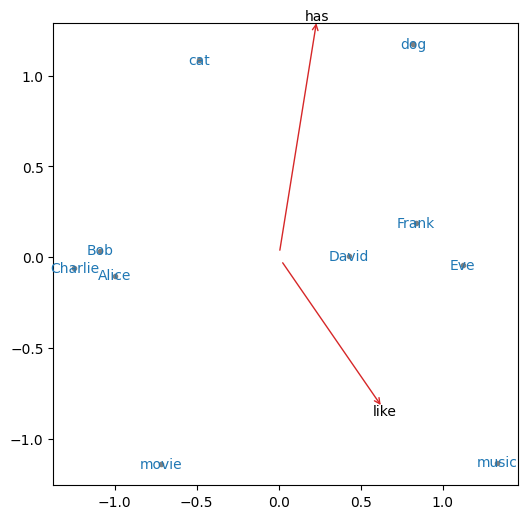

In [101]:
# Get the entity and relation embeddings
entitie_list=list(triples_factory.entity_to_id.keys())
relation_list =list(triples_factory.relation_to_id.keys())

entity_embeddings = model.get_embeddings(
       entitie_list,
        embedding_type='e'
    )
relation_embeddings = model.get_embeddings(
        relation_list, 
        embedding_type='r'
    )

# Perform PCA on the embeddings
pca = PCA(n_components=2)
m = pca.fit(entity_embeddings)

# Plot the embeddings
eu = m.transform(entity_embeddings)
plt.figure(figsize=(6, 6))

plt.scatter(eu[:, 0], eu[:, 1], color='gray',marker='.')
for i, entity in enumerate(entitie_list):
#     plt.annotate(entity, (eu[i, 0], eu[i, 1]))
    plt.annotate(
        text=entity,
        xy=(eu[i, 0], eu[i, 1]),
        color="tab:blue",
        ha="center", va="center"
    )

ru = m.transform(relation_embeddings)    
# plt.scatter(ru[:, 0], ru[:, 1], color='red')
for i, relation in enumerate(relation_list):
#     plt.annotate(relation, (ru[i, 0], ru[i, 1]))
    plt.annotate(
        text=relation,
        xy=(0,0), xytext=(ru[i, 0], ru[i, 1]),
        arrowprops=dict(
            arrowstyle="<-",
            color="tab:red",
            shrinkA=5,
            shrinkB=5,
            patchA=None,
            patchB=None,
            connectionstyle="arc3,rad=0."
        )
    )

    
# plt.xlim([-3, 3])
# plt.ylim([-3, 3])

plt.show()